# 利用 AWS SageMaker BlazingText 对不均衡文本进行多分类

## 没有经过样本不均衡处理的 baseline 实验

1. Step 0 - Setup； 
2. Step 1 - 数据集分析； 
3. Step 2 - 数据预处理；
4. Step 3 - 模型训练;
5. Step 4 - 模型部署，评估和测试

## Step 0 - Setup

指定用于存放训练和模型数据的S3存储桶和前缀。

并指定 IAM 角色用于授予SageMaker访问数据的权限。

In [67]:
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import json
import boto3
from random import shuffle

sess = sagemaker.Session()

role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = 'ray-ai-ml-bjs' #sess.default_bucket() # Replace with your own bucket name if needed
input_prefix = 'classification/blazingtext/UnbalancedTextMulticlassification'

arn:aws-cn:iam::876820548815:role/Sagemaker-Bootcamp-SageMakerExecutionRole-Z3VF78G260T1


## Step 1 - 数据集分析

In [68]:
import pandas as pd

step1_df = pd.read_csv('unblance_original_dataset/dataset.csv')
print("行数：" + str(step1_df.shape[0]))
step1_df.head()

行数：188020


,label,title,abstract
0,1,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...
1,1,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...
2,1,Q-workshop,Q-workshop is a Polish company located in Poz...
3,1,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...
4,1,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...


3. 查看一共有哪些类别以及每个类别数据的数量分布情况

In [69]:
count_classes = pd.value_counts(step1_df['label'], sort = True)
print(count_classes)

1     40000
2     38000
3     18000
4     17000
5     16000
6     15000
7     14000
8     13000
9      8000
10     5000
11     3000
12      900
13      100
14       20
Name: label, dtype: int64


4. 查看数据集的类别分布情况，包括每个类别的数量，并画好分布图。

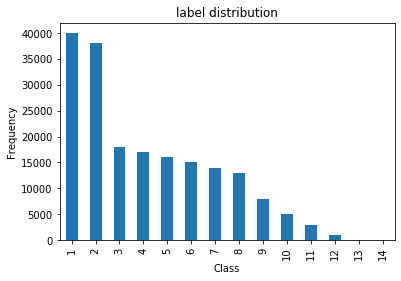

In [70]:
import matplotlib.pyplot as plt

count_classes = step1_df.label.value_counts()
count_classes.plot(kind = 'bar')
plt.title("label distribution")
plt.xlabel("Class")
plt.ylabel("Frequency");

5. 查看数字类别对应的名称

In [71]:
!cat unblance_original_dataset/classes.txt

Company
EducationalInstitution
Artist
Athlete
OfficeHolder
MeanOfTransportation
Building
NaturalPlace
Village
Animal
Plant
Album
Film
WrittenWork


6. 创建从整数索引到类标签的字典映射

In [72]:
index_to_label = {} 
with open("unblance_original_dataset/classes.txt") as f:
    for i,label in enumerate(f.readlines()):
        index_to_label[str(i+1)] = label.strip()
print(index_to_label)

{'1': 'Company', '2': 'EducationalInstitution', '3': 'Artist', '4': 'Athlete', '5': 'OfficeHolder', '6': 'MeanOfTransportation', '7': 'Building', '8': 'NaturalPlace', '9': 'Village', '10': 'Animal', '11': 'Plant', '12': 'Album', '13': 'Film', '14': 'WrittenWork'}


## Step 2 - 数据预处理

1. 去掉空行；
2. 大小写统一；
3. 分词 - 英文分词使用nltk.word_tokenize；中文可以使用jieba分词
4. 转化为BlazingText的数据集格式

In [73]:
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

1. 按照blazingtext的要求，创建从整数索引到以“__label__”开头的类标签的字典映射

In [74]:
index_to_label_final = {}
for key in index_to_label:
    index_to_label_final[key] = "__label__" + str(index_to_label[key]) 

print(index_to_label_final)

{'1': '__label__Company', '2': '__label__EducationalInstitution', '3': '__label__Artist', '4': '__label__Athlete', '5': '__label__OfficeHolder', '6': '__label__MeanOfTransportation', '7': '__label__Building', '8': '__label__NaturalPlace', '9': '__label__Village', '10': '__label__Animal', '11': '__label__Plant', '12': '__label__Album', '13': '__label__Film', '14': '__label__WrittenWork'}


2. 分词和预处理：把Title和Abstract合并，按照blazingtext要求生成新的label格式

In [75]:
def tokenize(series):
    for index, value in series.items():
        series[index] = nltk.word_tokenize(value.lower())
    return series

def preprocess(step1_df):
    
    step1_df = step1_df.dropna(axis=0) 
    
    step2_df = pd.DataFrame()
    step2_df['label'] = step1_df['label']
    step2_df['label'] = step2_df['label'].map(str).map(index_to_label_final)
    step2_df['sentence'] = step1_df["title"].map(str) +","+ step1_df["abstract"].map(str)
    #comments off the tokenize, which will cause the classification_report error
    #step2_df['sentence'] = tokenize(step2_df['sentence']) 
    return step2_df

step2_df = preprocess(step1_df)
step2_df.head(10)

,label,sentence
0,__label__Company,"E. D. Abbott Ltd, Abbott of Farnham E D Abbott..."
1,__label__Company,"Schwan-Stabilo, Schwan-STABILO is a German mak..."
2,__label__Company,"Q-workshop, Q-workshop is a Polish company loc..."
3,__label__Company,"Marvell Software Solutions Israel, Marvell Sof..."
4,__label__Company,"Bergan Mercy Medical Center, Bergan Mercy Medi..."
5,__label__Company,"The Unsigned Guide, The Unsigned Guide is an o..."
6,__label__Company,"Rest of the world, Within sports and games pla..."
7,__label__Company,"Globoforce, Globoforce is a multinational comp..."
8,__label__Company,"Rompetrol, The Rompetrol Group N.V. is a Roman..."
9,__label__Company,"Wave Accounting, Wave is the brand name for a ..."


3. 保留预处理后的数据集作为baseline实验的数据集

In [76]:
import os

os.makedirs('unblance_baseline_dataset', exist_ok = True)
step2_df.to_csv("unblance_baseline_dataset/dataset_baseline.csv", sep=" ", header=0, index=0)

## Step3 - 模型训练

1. 划分训练集和测试集, 85% 训练集，15% 验证集

In [77]:
import numpy as np
from sklearn.model_selection import train_test_split

baseline_train, baseline_test = train_test_split(step2_df, test_size=0.15)
baseline_train.to_csv("unblance_baseline_dataset/baseline_train.csv", sep=" ", header=0, index=0)
baseline_test.to_csv("unblance_baseline_dataset/baseline_test.csv", sep=" ", header=0, index=0)

2. 上传到S3

In [78]:
train_channel = input_prefix + '/baseline' + '/train'
validation_channel = input_prefix + '/baseline' + '/validation'

sess.upload_data(path='unblance_baseline_dataset/baseline_train.csv', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='unblance_baseline_dataset/baseline_test.csv', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

3. 获取blazingtext模型

In [79]:
s3_output_location = 's3://{}/{}/baseline/output'.format(bucket, input_prefix)
region_name = boto3.Session().region_name

container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Using SageMaker BlazingText container: 390948362332.dkr.ecr.cn-north-1.amazonaws.com.cn/blazingtext:latest (cn-north-1)


4. 创建训练预测模型和超参调优

In [80]:
baseline_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

baseline_model.set_hyperparameters(mode="supervised",
                            epochs=10,
                            min_count=2,
                            learning_rate=0.05,
                            vector_dim=10,
                            early_stopping=True,
                            patience=4,
                            min_epochs=5,
                            word_ngrams=2)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


5. 模型输入

In [81]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')

validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data}

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


6. 模型训练

In [82]:
baseline_model.fit(inputs=data_channels, logs=True)

2020-11-17 10:50:26 Starting - Starting the training job...
2020-11-17 10:50:29 Starting - Launching requested ML instances......
2020-11-17 10:51:39 Starting - Preparing the instances for training......
2020-11-17 10:52:41 Downloading - Downloading input data......
2020-11-17 10:53:50 Training - Downloading the training image..Arguments: train
[11/17/2020 10:54:08 WARNING 139943614920064] Loggers have already been setup.
[11/17/2020 10:54:08 WARNING 139943614920064] Loggers have already been setup.
[11/17/2020 10:54:08 INFO 139943614920064] nvidia-smi took: 0.02529120445251465 secs to identify 0 gpus
[11/17/2020 10:54:08 INFO 139943614920064] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[11/17/2020 10:54:08 INFO 139943614920064] Processing /opt/ml/input/data/train/baseline_train.csv . File size: 52.89375019073486 MB
[11/17/2020 10:54:08 INFO 139943614920064] Processing /opt/ml/input/data/validation/baseline_test.c

## Step4 - Baseline 模型部署

In [83]:
baseline_classifier = baseline_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

## Step 5 - Baseline 模型评估和测试

In [84]:
from sklearn.metrics import classification_report
import json

sentences = baseline_test['sentence'].tolist()
print(sentences[0])
# print(sentenses)

payload = {"instances" : sentences}
response = baseline_classifier.predict(json.dumps(payload))
predictions = json.loads(response)
#print('predictions', predictions)

predict_label = []
for one in predictions:
#     print(one['label'][0])
    predict_label.append(one['label'][0])
# print(predict_label)

real_label = baseline_test['label'].tolist()
# print(real_label)

baseline_report = classification_report(real_label, predict_label)
print(baseline_report)

Kinross Gold, Kinross Gold Corporation is a Canadian-based gold mining company with mines and projects in Canada the United States Brazil Chile Russia Ghana and Mauritania. Kinross was founded after a merger in 1993 of three companies initially owning a mine in British Columbia and royalties on a mine in Nevada. Following a series of takeovers and mergers Kinross now owns nine active gold mines on four continents.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

                 __label__Album       0.94      0.89      0.91       120
                __label__Animal       0.94      0.94      0.94       761
                __label__Artist       0.95      0.97      0.96      2744
               __label__Athlete       0.99      0.98      0.99      2561
              __label__Building       0.95      0.94      0.95      2123
               __label__Company       0.97      0.97      0.97      5902
__label__EducationalInstitution       0.99      0.98      0.99      5642
                  __label__Film       0.00      0.00      0.00        18
  __label__MeanOfTransportation       0.97      0.98      0.98      2234
          __label__NaturalPlace       0.98      0.99      0.98      2004
          __label__OfficeHolder       0.98      0.96      0.97      2422
                 __label__Plant       0.96      0.87      0.91       460
               __label__Village       0.99      0.

2. 预测结束，删除endpoint

In [85]:
baseline_classifier.delete_endpoint()

# 没有经过样本不均衡处理的Baseline超参调优实验

    Step 1 - 超参自动调优配置 learning_rate， vector_dim， word_ngrams
    Step 2 - 启动超参数优化作业和模型训练
    Step 3 - 模型部署，评估和测试


## Step 1 设置超参数优化作业

这里我们没有设置learning_rate, vector_dim, word_ngrams 三个超参，让SageMaker帮我们进行超参自动调优

In [86]:
baseline_hyperparameter_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

baseline_hyperparameter_model.set_hyperparameters(
                            mode="supervised",
                            epochs=10,
                            min_count=2,
                            early_stopping=True,
                            patience=4,
                            min_epochs=5)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [87]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'learning_rate': ContinuousParameter(0.03, 0.06),
                         'vector_dim': IntegerParameter(100, 200),
                         'word_ngrams': IntegerParameter(1, 3)}

objective_metric_name = 'validation:accuracy'

tuner = HyperparameterTuner(baseline_hyperparameter_model,
                            objective_metric_name,
                            hyperparameter_ranges,
                            objective_type='Maximize',
                            max_jobs=9,
                            max_parallel_jobs=3)

## Step 2 - 启动超参数优化作业和模型训练

In [ ]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H-%M-%S")
print(current_time)

tuner.fit(inputs=data_channels, job_name="hyperparam-baseline-job"+current_time, logs=True)

tuner.wait()

11-18-01
..................................................................................................

In [95]:
tuner.describe()['BestTrainingJob']

{'TrainingJobName': 'hyperparam-baseline-job11-18-01-007-e8466aff',
 'TrainingJobArn': 'arn:aws-cn:sagemaker:cn-north-1:876820548815:training-job/hyperparam-baseline-job11-18-01-007-e8466aff',
 'CreationTime': datetime.datetime(2020, 11, 17, 11, 28, 43, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2020, 11, 17, 11, 31, 7, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2020, 11, 17, 11, 32, 17, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'learning_rate': '0.05792394606493767',
  'vector_dim': '163',
  'word_ngrams': '1'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:accuracy',
  'Value': 0.9753000140190125},
 'ObjectiveStatus': 'Succeeded'}

In [97]:
baseline_hyperparameter_classifier = tuner.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


2020-11-17 11:32:17 Starting - Preparing the instances for training
2020-11-17 11:32:17 Downloading - Downloading input data
2020-11-17 11:32:17 Training - Training image download completed. Training in progress.
2020-11-17 11:32:17 Uploading - Uploading generated training model
2020-11-17 11:32:17 Completed - Training job completedArguments: train
[11/17/2020 11:31:40 WARNING 139665596355968] Loggers have already been setup.
[11/17/2020 11:31:40 WARNING 139665596355968] Loggers have already been setup.
[11/17/2020 11:31:40 INFO 139665596355968] nvidia-smi took: 0.02521204948425293 secs to identify 0 gpus
[11/17/2020 11:31:40 INFO 139665596355968] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[11/17/2020 11:31:40 INFO 139665596355968] tuning_objective_metric: validation:accuracy
[11/17/2020 11:31:40 INFO 139665596355968] Processing /opt/ml/input/data/train/baseline_train.csv . File size: 52.89375019073486 MB
[11/17/

## Step 3 模型评估和测试

In [98]:
from sklearn.metrics import classification_report
import json

sentences = baseline_test['sentence'].tolist()
# print(sentenses)

payload = {"instances" : sentences}
response = baseline_hyperparameter_classifier.predict(json.dumps(payload))
predictions = json.loads(response)
# print(predictions)

predict_label = []
for one in predictions:
#     print(one['label'][0])
    predict_label.append(one['label'][0])
# print(predict_label)

real_label = baseline_test['label'].tolist()
# print(real_label)

baseline_hyperparameter_report = classification_report(real_label, predict_label)
print(baseline_hyperparameter_report)

print(baseline_report)

                                 precision    recall  f1-score   support

                 __label__Album       0.88      0.94      0.91       120
                __label__Animal       0.97      0.95      0.96       761
                __label__Artist       0.96      0.97      0.97      2744
               __label__Athlete       0.99      0.99      0.99      2561
              __label__Building       0.96      0.94      0.95      2123
               __label__Company       0.97      0.97      0.97      5902
__label__EducationalInstitution       0.99      0.99      0.99      5642
                  __label__Film       0.00      0.00      0.00        18
  __label__MeanOfTransportation       0.98      0.99      0.98      2234
          __label__NaturalPlace       0.98      0.99      0.98      2004
          __label__OfficeHolder       0.98      0.97      0.97      2422
                 __label__Plant       0.96      0.95      0.95       460
               __label__Village       0.98      0.

## 预测结束，删除endpoint


In [99]:
baseline_hyperparameter_classifier.delete_endpoint()